# Chapter 07 - Topology optimization

In [18]:
import torch
from math import sqrt
from simple_fem import get_cantilever

## Define the cantilever problem

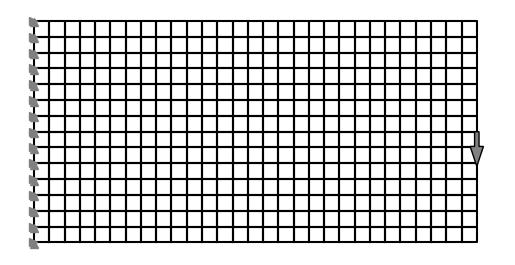

In [19]:
import matplotlib.pyplot as plt

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True

cantilever = get_cantilever(1.0, 30.0, 15.0)
cantilever.plot()


## Optimization with MMA

In [20]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def optimize_mma(fem, d_0, d_min, d_max, V_0, iter=15, s=0.7, p=1.0):
    d = [d_0]
    L = []
    a = fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(d_min, a) > V_0:
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the problem at point x_k
        u_k, f_k = fem.solve(d[k])

        # Get strain energy of all elements for the given displacement
        w_k = fem.element_strain_energies(u_k)

        # Compute lower asymptote
        if k <= 1:
            L_k = d[k] - s * (d_max - d_min)
        else:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (d[k][j] - d[k - 1][j]) * (d[k - 1][j] - d[k - 2][j]) < 0.0:
                    L_k[j] = d[k][j] - s * (d[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = d[k][j] - 1 / sqrt(s) * (d[k - 1][j] - L[k - 1][j])
        L.append(L_k)

        # Compute lower move limit in this step
        d_min_k = torch.maximum(d_min, 0.9 * L[k] + 0.1 * d[k])

        # Analytical solution
        def d_star(mu):
            EPS = 1e-15
            sens = 2 * p*d[k]**(p-1) * w_k
            d_hat = L[k] + torch.sqrt(
                (sens * (L[k] - d[k]) ** 2 + EPS) / (mu * a + EPS)
            )
            return torch.maximum(torch.minimum(d_hat, d_max), d_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(d_star(mu), a) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 0.0, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        d.append(d_star(mu_star))

    return d


## Variable thickness optimization (p=1)

Iteration k=0 - Compliance: 0.35658
Iteration k=1 - Compliance: 0.62236
Iteration k=2 - Compliance: 0.51817
Iteration k=3 - Compliance: 0.51317
Iteration k=4 - Compliance: 0.51026
Iteration k=5 - Compliance: 0.50942
Iteration k=6 - Compliance: 0.50839
Iteration k=7 - Compliance: 0.50786
Iteration k=8 - Compliance: 0.50764
Iteration k=9 - Compliance: 0.50754
Iteration k=10 - Compliance: 0.50746
Iteration k=11 - Compliance: 0.50739
Iteration k=12 - Compliance: 0.50734
Iteration k=13 - Compliance: 0.50730
Iteration k=14 - Compliance: 0.50728


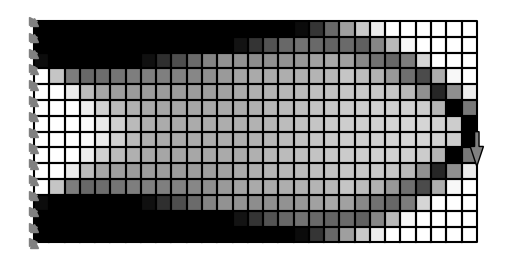

In [21]:
d_0 = torch.ones(cantilever.elements.shape[0])
d_min = 0.1 * torch.ones_like(d_0)
d_max = 1.0 * torch.ones_like(d_0)
areas = cantilever.areas()
V0 = 0.5 * torch.inner(d_max, areas)

d_opt = optimize_mma(cantilever, d_0, d_min, d_max, V0)
cantilever.plot(element_property=d_opt[-1])
plt.savefig("figures/cantilever_fem_optimized.pdf", transparent=True, bbox_inches="tight")

## SIMP approach for binarization

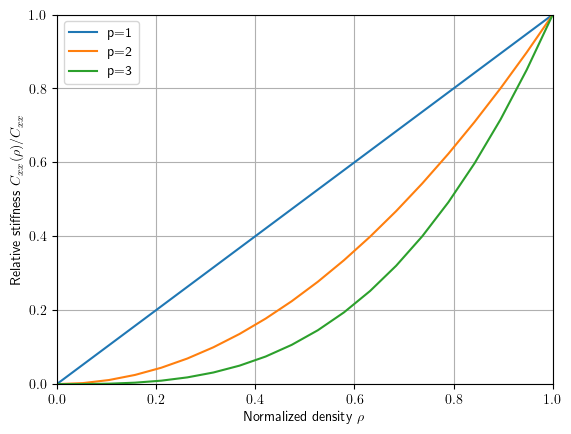

In [28]:
p = 3
Cxx = 1.0

# Plot the SIMP relation
rho = torch.linspace(0,1,20)
plt.plot(rho, Cxx * rho**1.0, label="p=1")
plt.plot(rho, Cxx * rho**2.0, label="p=2")
plt.plot(rho, Cxx * rho**3.0, label="p=3")
plt.xlabel(r"Normalized density $\rho$")
plt.ylabel(r"Relative stiffness $C_{xx}(\rho)/C_{xx}$")
plt.xlim([0, 1])
plt.ylim([0, Cxx])
plt.legend()
plt.grid()
plt.savefig("figures/simp.pdf", transparent=True, bbox_inches="tight")

Iteration k=0 - Compliance: 0.35658
Iteration k=1 - Compliance: 0.62236
Iteration k=2 - Compliance: 0.52078
Iteration k=3 - Compliance: 0.51886
Iteration k=4 - Compliance: 0.52656
Iteration k=5 - Compliance: 0.53050
Iteration k=6 - Compliance: 0.53220
Iteration k=7 - Compliance: 0.53128
Iteration k=8 - Compliance: 0.52955
Iteration k=9 - Compliance: 0.53052
Iteration k=10 - Compliance: 0.53245
Iteration k=11 - Compliance: 0.53541
Iteration k=12 - Compliance: 0.53742
Iteration k=13 - Compliance: 0.54047
Iteration k=14 - Compliance: 0.54326
Iteration k=15 - Compliance: 0.54407
Iteration k=16 - Compliance: 0.54496
Iteration k=17 - Compliance: 0.54638
Iteration k=18 - Compliance: 0.54748
Iteration k=19 - Compliance: 0.54842
Iteration k=20 - Compliance: 0.54833
Iteration k=21 - Compliance: 0.54833
Iteration k=22 - Compliance: 0.54831
Iteration k=23 - Compliance: 0.54831
Iteration k=24 - Compliance: 0.54831


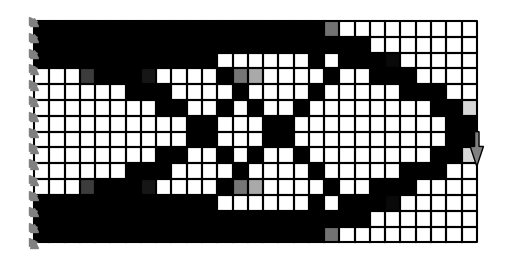

In [23]:
d_opt = optimize_mma(cantilever, d_0, d_min, d_max, V0, p=2, iter=25)
cantilever.plot(element_property=d_opt[-1])
plt.savefig("figures/cantilever_fem_optimized_binary.pdf", transparent=True, bbox_inches="tight")

## Optimization with optimality conditions

In [24]:
def optimize_oc(fem, d_0, d_min, d_max, V_0, iter=15, xi=0.5, move=0.2, p=1):
    d = [d_0]
    areas = fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(d_min, areas) > V_0:
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        u_k, f_k = fem.solve(d[k])
        d_k = d[k].clone()
        sensitivity = p*d_k**(p-1) * fem.element_strain_energies(u_k)

        def make_step(mu):
            # Assuming a certain value of mu, apply the iteration scheme to 
            G_k = sensitivity / (mu * areas)
            upper = torch.min(d_max, (1 + move) * d_k)
            lower = torch.max(d_min, (1 - move) * d_k)
            d_trial = G_k**xi * d_k
            return torch.maximum(torch.minimum(d_trial, upper), lower)

        def g(mu):
            d_k = make_step(mu)
            return torch.dot(d_k, areas) - V_0

        mu = bisection(g, 0.00001, 0.2, tol=1e-15)


        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        d.append(make_step(mu))

    return d

Iteration k=0 - Compliance: 0.35658
Iteration k=1 - Compliance: 0.44572
Iteration k=2 - Compliance: 0.55715
Iteration k=3 - Compliance: 0.69644
Iteration k=4 - Compliance: 0.62751
Iteration k=5 - Compliance: 0.57491
Iteration k=6 - Compliance: 0.53778
Iteration k=7 - Compliance: 0.51658
Iteration k=8 - Compliance: 0.51263
Iteration k=9 - Compliance: 0.51033
Iteration k=10 - Compliance: 0.50874
Iteration k=11 - Compliance: 0.50805
Iteration k=12 - Compliance: 0.50778
Iteration k=13 - Compliance: 0.50760
Iteration k=14 - Compliance: 0.50748


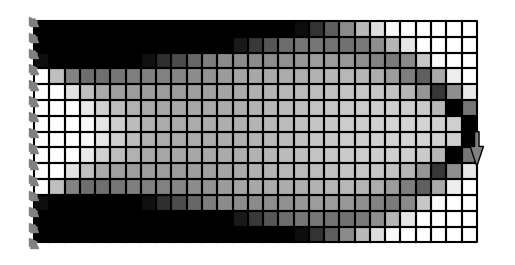

In [25]:
d_opt = optimize_oc(cantilever, d_0, d_min, d_max, V0)
cantilever.plot(element_property=d_opt[-1])